# Removing bias enables generalization

In this notebook, we look at the generalization comparisons between a given model (e.g. DnCNN), and its bias free  version (e.g. BF_DnCNN). 

Inside the training range, the two models show comparable performance. However, outside the training range, bias free network, outperforms the other network significantly. 

In this notebook, we look at

1. comparative performance of the models on single images. 

2. comparative performance of the models averaged across many images. 

3. behavior of net bias inside and outside the training range




In [ ]:
pretrained_base = './pretrained/'
data_base = '../data/'

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch
import torch.nn as nn

import argparse
from torch.serialization import default_restore_location

from skimage.measure.simple_metrics import compare_psnr, compare_mse
from skimage.measure import compare_ssim

import os
import sys  
import models

%matplotlib inline

### Load both trained models: 1) model with net bias, 2) model without net bias

In [23]:
USE_CUDA = True

device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu') 

In [24]:
def load_model(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})

    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [ ]:
model = 'dncnn'
min_noise = 0
max_noise = 10

In [ ]:
DnCNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))

In [27]:
BF_DnCNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))

In [28]:
# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 


In [29]:
l = min_noise
h = max_noise

### Show 4 random noisy images used during training for this model 


In [30]:
from skimage import io
def single_image_loader(data_set_dire_path, image_number):
    all_names = os.listdir(data_set_dire_path)
    all_names.sort()
    file_name = all_names[image_number]
    im = io.imread(data_set_dire_path + file_name).astype(float)/255
    return im

In [31]:
def add_noise(all_patches, noise_level, mode='B'):
    all_patches_noisy = []
    all_noises = []

    for i in range(all_patches.shape[0]):
        #for blind denoising
        if mode == 'B':
            std = np.int(np.random.randint(noise_level[0], noise_level[1] , size = 1))/255
        #for specific noise
        else:
            std = noise_level/255
        noise =np.random.normal(loc=0.0, scale=  std, size= (all_patches.shape[1], all_patches.shape[2]))
        all_patches_noisy.append( all_patches[i:i+1] + noise)
        all_noises.append(noise)

    return np.concatenate(all_patches_noisy, axis = 0), np.stack(all_noises, axis = 0)


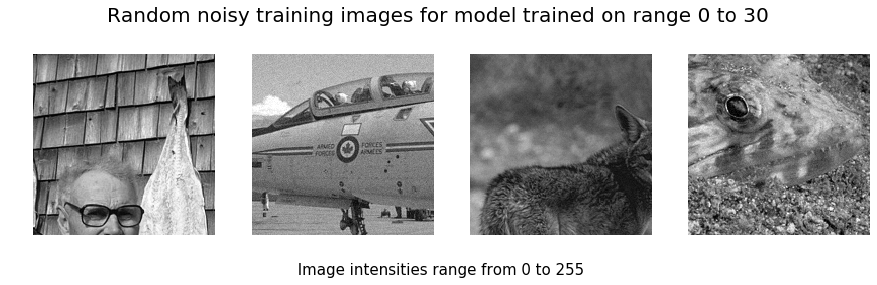

In [32]:
f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)
f.suptitle('Random noisy training images for model trained on range ' + str(min_noise) +' to '+ str(max_noise),  fontname= 'Times New Roman', fontsize = 20)
f.text(.5, .05, ' Image intensities range from 0 to 255',ha='center',  fontname= 'Times New Roman', fontsize = 15)
for i in range(4): 
    tr_im_n = np.random.randint(0,len(os.listdir(train_folder_path)))
    tr_im = single_image_loader(train_folder_path, tr_im_n)
    tr_dim1, tr_dim2 = tr_im.shape
    tr_noisy, _ = add_noise(tr_im.reshape(1,tr_dim1,tr_dim2), [0,10], 'B') 
    tr_noisy = tr_noisy.reshape(tr_dim1,tr_dim2)
    axs[i].imshow(tr_noisy, 'gray', vmin= 0, vmax = 1)
    axs[i].axis('off');
    

## 1. Comparing performance on a single image 

In [35]:
# choose the image number from the dataset 
image_num = 7

clean_im = single_image_loader(set12_path, image_num)
dim1, dim2 = clean_im.shape

# choose noise level  
noise_level = 90 # relative to image intenstities in range (0,255)


noisy_im, noise = add_noise(clean_im.reshape(1,dim1,dim2), noise_level, 'S') 

inp_test = torch.FloatTensor(noisy_im).unsqueeze(1).to(device)

residual_dncnn= DnCNN(inp_test).cpu().data.squeeze(0).squeeze(0).numpy()
residual_bf_dncnn= BF_DnCNN(inp_test).cpu().data.squeeze(0).squeeze(0).numpy()


/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  del sys.path[0]
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/home/sm7582/condaenvs/denoising/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be r

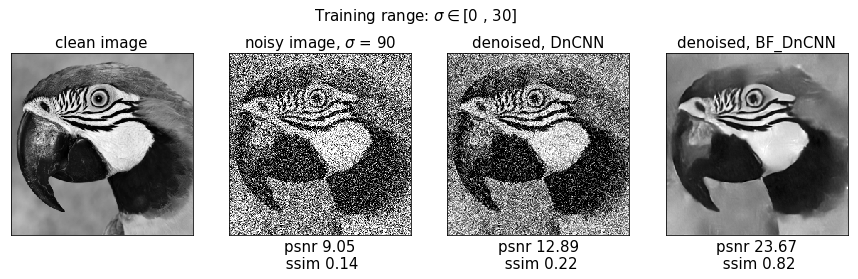

In [36]:
noisy_im = noisy_im.reshape(dim1,dim2)
denoised_dncnn =  residual_dncnn.reshape(dim1,dim2)
denoised_bf_dncnn =  residual_bf_dncnn.reshape(dim1,dim2)

f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)

f.suptitle(r'Training range: $\sigma \in [ $' + str(l) +' , '+ str(h) + ']',  fontname= 'Times New Roman', fontsize = 15)

axs[0].imshow(clean_im, 'gray', vmin= 0, vmax = 1)
axs[0].set_title('clean image', fontname= 'Times New Roman', fontsize = 15)

axs[1].imshow(noisy_im, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, noisy_im),2)
ssim = np.round(compare_ssim(clean_im, noisy_im),2)
axs[1].set_title(r'noisy image, $\sigma$ = '+str(noise_level), fontname= 'Times New Roman', fontsize = 15)
axs[1].set_xlabel('psnr ' +str(psnr) + '\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

axs[2].imshow(denoised_dncnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_dncnn),2)
ssim = np.round(compare_ssim(clean_im, denoised_dncnn),2)
axs[2].set_title('denoised, DnCNN', fontname= 'Times New Roman', fontsize = 15)
axs[2].set_xlabel('psnr ' +str(psnr)+'\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

axs[3].imshow(denoised_bf_dncnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_bf_dncnn),2)
ssim = np.round(compare_ssim(clean_im, denoised_bf_dncnn),2)
axs[3].set_title('denoised, BF_DnCNN', fontname= 'Times New Roman', fontsize = 15)
axs[3].set_xlabel('psnr ' +str(psnr)+'\n ssim '+str(ssim), fontname= 'Times New Roman', fontsize = 15)

for i in range(4): 
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)



## 2. Comparing performance across many images

The following plot shows output PSNR against input PSNR for DnCNN vs. BFCNN.

In order to calculate PSNR on set 68 using another model, run psnr68_calculator.py. The results will be saved in the model's results folder. 


In [37]:
import utils

In [38]:
noise_std_range = np.arange(10,110,10)/255.

In [39]:
metrics_bfcnn = utils.metrics_avg_on_noise_range(BF_DnCNN, test_folder_path, noise_std_range, device = device )

../data/Test/Set68/
noise:  10   psnr :  33.666248049972495
noise:  10   psnr_delta :  5.405000003204059
noise:  10   ssim :  0.9245868453760862
noise:  10   ssim_delta :  0.20151105592072183
noise:  20   psnr :  30.12759849396829
noise:  20   psnr_delta :  7.777497874826487
noise:  20   ssim :  0.8521220205877563
noise:  20   ssim_delta :  0.36124893845219835
noise:  30   psnr :  28.252483720178372
noise:  30   psnr_delta :  9.282361156062107
noise:  30   ssim :  0.7942745864204265
noise:  30   ssim_delta :  0.436417808347573
noise:  40   psnr :  26.9815582339784
noise:  40   psnr_delta :  10.339804399708527
noise:  40   ssim :  0.7442173770316927
noise:  40   ssim_delta :  0.4700006349203109
noise:  50   psnr :  26.046082254516328
noise:  50   psnr_delta :  11.133218145235123
noise:  50   ssim :  0.7017162122234732
noise:  50   ssim_delta :  0.4836942275182474
noise:  60   psnr :  25.294739783672593
noise:  60   psnr_delta :  11.73015518887208
noise:  60   ssim :  0.6656248387156366


In [40]:
metrics_dncnn = utils.metrics_avg_on_noise_range(DnCNN, test_folder_path, noise_std_range, device = device )

../data/Test/Set68/
noise:  10   psnr :  33.77528943116798
noise:  10   psnr_delta :  5.51736240772205
noise:  10   ssim :  0.9275104231841116
noise:  10   ssim_delta :  0.20444148590802372
noise:  20   psnr :  30.215205725442583
noise:  20   psnr_delta :  7.863194184446316
noise:  20   ssim :  0.8570055924791388
noise:  20   ssim_delta :  0.3660187361838965
noise:  30   psnr :  28.37534512562795
noise:  30   psnr_delta :  9.407529775946323
noise:  30   ssim :  0.8060546693841496
noise:  30   ssim_delta :  0.44822284171582777
noise:  40   psnr :  23.211754943165122
noise:  40   psnr_delta :  6.569295045085454
noise:  40   ssim :  0.5226461146860361
noise:  40   ssim_delta :  0.24850192414143463
noise:  50   psnr :  18.83647008107136
noise:  50   psnr_delta :  3.921971408702629
noise:  50   ssim :  0.3320322524684449
noise:  50   ssim_delta :  0.11401894729415338
noise:  60   psnr :  16.59153196554263
noise:  60   psnr_delta :  3.02501556686029
noise:  60   ssim :  0.2531074139691974
no

In [41]:
dncnn_psnr68 = metrics_dncnn['psnr']
bf_dncnn_psnr68 = metrics_bfcnn['psnr']

dncnn_ssim68 = metrics_dncnn['ssim']
bf_dncnn_ssim68 = metrics_bfcnn['ssim']

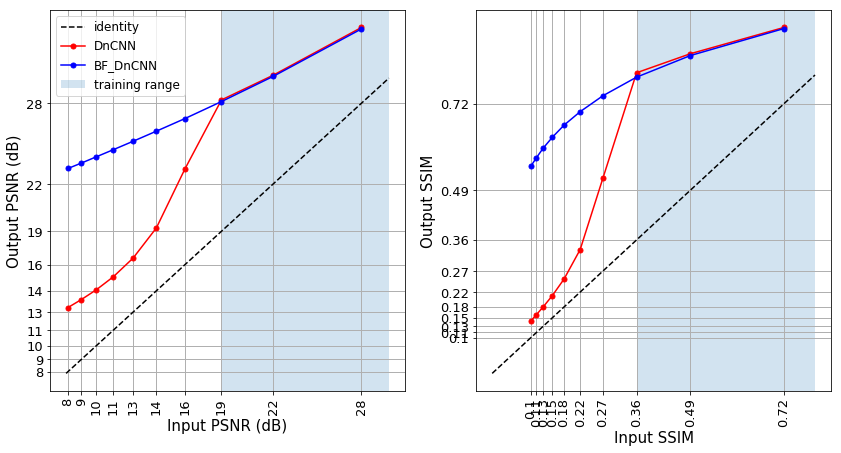

In [42]:
f , axs = plt.subplots(1,2, figsize=(14,7))


#### PSNR
# dncnn_psnr68 = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')
# bf_dncnn_psnr68 = np.load('models/BF_DnCNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')
x_axis = [ -10*np.log10( (s/255)**2  ) for s in range(10,110,10)]
axs[0].plot( [8,30],[8,30] ,'k--', alpha = 1, label = 'identity');
axs[0].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
axs[0].set_yticklabels(np.round(x_axis).astype(int) , fontsize=13, fontname= 'Times New Roman');
axs[0].set_xlabel('Input PSNR (dB)', fontsize=15, fontname= 'Times New Roman')
axs[0].set_ylabel('Output PSNR (dB)', fontsize=15, fontname= 'Times New Roman')        
axs[0].plot(x_axis, dncnn_psnr68, color = 'red', marker = '.',markersize = 10, label = 'DnCNN')
axs[0].plot(x_axis, bf_dncnn_psnr68, color = 'blue', marker = '.',markersize = 10, label = 'BF_DnCNN')
axs[0].set_xticks(x_axis)
axs[0].set_yticks(x_axis)
axs[0].grid(linewidth=1)
if l != 0:
    axs[0].axvspan(-10*np.log10( (h/255)**2) , -10*np.log10( (l/255)**2)  , alpha=0.2, label='training range');        
else: 
    axs[0].axvspan(-10*np.log10( (h/255)**2) , 30  , alpha=0.2, label='training range');
axs[0].legend(fontsize = 12);

#### SSIM 
# dncnn_ssim68 = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_list.npy')
# bf_dncnn_ssim68 = np.load('models/BF_DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_list.npy')
# x_axis = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/ssim68_input.npy')
x_axis = metrics_dncnn['ssim'] -metrics_dncnn['ssim_delta']
axs[1].plot( [0,.8],[0,.8] ,'k--', alpha = 1, label = 'identity');
axs[1].set_xticklabels(np.round(x_axis,2) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
axs[1].set_yticklabels(np.round(x_axis,2) , fontsize=13, fontname= 'Times New Roman');
axs[1].set_xlabel('Input SSIM', fontsize=15, fontname= 'Times New Roman')
axs[1].set_ylabel('Output SSIM', fontsize=15, fontname= 'Times New Roman')
axs[1].plot(x_axis, dncnn_ssim68, color = 'red', marker = '.',markersize = 10, label = 'DnCNN')
axs[1].plot(x_axis, bf_dncnn_ssim68, color = 'blue', marker = '.',markersize = 10, label = 'BF_DnCNN')
axs[1].set_xticks(x_axis)
axs[1].set_yticks(x_axis)
if l != 0:
    axs[1].axvspan( x_axis[int(h/10)-1] ,x_axis[int(l/10)-1], alpha=0.2, label='training range');        
else: 
    axs[1].axvspan( x_axis[int(h/10)-1] ,.8 , alpha=0.2, label='training range');
axs[1].grid(linewidth=1)


## 3. Network bias impairs generalization 

A regular network with ReLU nonlinearities can be thought of as a cascade of affine transformations. For such network, we can break down the total transformation to two components: linear part, and the net bias. We observed that the net bias is always pushed to zero inside the training range. However outside the training range, it explodes. This coincides with the significant denoising performance drop, reflected in divergence of residual from the identity line. By removing the bias from the network we push it to be zero even outside the training range. This results in a surprisingly dramatic boost in performance, which is reflected in residual estimating the noise much better (i.e. residual is close to identity).

The following plots show the norms of the residual and the net bias averaged over 100 $20 \times 20$ natural-image patches. 
 
 
In order to try this results on another network, run bias_linear_decomp.py module, available in code folder. The averaged values will be saved in the model's results folder. 

In [ ]:
# Choose the training range of the model below. 
low = 0
high = 55

model_folder = ['DnCNN', 'BF_DnCNN']
im_d = 20 # size of the patch used 

f, axs = plt.subplots(1,2, figsize = (16,6), sharey=True)
plt.subplots_adjust()
for i in range(2):
    try: 
        folder_path = 'models/'+model_folder[i]+'/range_'+str(low)+'_'+str(high)+'/results'

        norm_b=np.load(folder_path  + '/norm_b_ave.npy'  )
        norm_res=np.load(folder_path  + '/norm_res_ave.npy'  )
        norm_noise=np.load(folder_path  + '/norm_noise_ave.npy'  )

        axs[i].plot( range(5,105,5),255* norm_b/im_d, 'g-o',label = r'bias, $b_y$', alpha = 1)
        axs[i].plot( range(5,105,5),255* norm_res/im_d, 'r-o',label = r'residual, $y-\hat{x}=(I-A_y)y-b_y$', alpha = .5)
        axs[i].plot( range(5,105,5),255* norm_noise/im_d, '--',label = r'noise, $z$', alpha = 1)

        axs[i].set_xticks(range(5,105,10))
        axs[i].set_yticks(range(5,105,10))

        axs[i].set_xlabel('noise level (sd)',fontsize=20, fontname= 'Times New Roman')
        axs[i].set_ylabel('error (sd) ',fontsize=20, fontname= 'Times New Roman')

        for tick in axs[i].get_xticklabels():
            tick.set_fontsize(15) 
            tick.set_fontname("Times New Roman")

        for tick in axs[i].get_yticklabels():
            tick.set_fontsize(15)
            tick.set_fontname("Times New Roman")

        axs[i].axvspan(low,high, alpha=0.2, label = 'training range');
        axs[i].legend(fontsize = 14);
        
    except FileNotFoundError:         
        print('Results not available for ' + model_folder[i] + ' trained on ' +str(low)+' to '+str(high))

    axs[i].set_title(model_folder[i],fontsize=20, fontname= 'Times New Roman')
        